In [1]:
import segyio

segyfile = segyio.open("../Dutch F3 seismic data/Dutch Government_F3_entire_8bit seismic.segy", "r") 

In [2]:
import segyio

data = segyio.tools.cube("../Dutch F3 seismic data/Dutch Government_F3_entire_8bit seismic.segy")

In [3]:
import numpy as np

files = ['multi_else_ilxl.pts',
         'multi_grizzly_ilxl.pts',
         'multi_high_amp_continuous_ilxl.pts',
         'multi_high_amplitude_ilxl.pts',
         'multi_low_amp_dips_ilxl.pts',
         'multi_low_amplitude_ilxl.pts',
         'multi_low_coherency_ilxl.pts',
         'multi_salt_ilxl.pts',
         'multi_steep_dips_ilxl.pts']

path = "../Dutch F3 seismic data/"
logs = []
for f in files:
    logs.append(np.loadtxt(path + f))

In [4]:
istep = np.diff(segyfile.ilines[:2])[0]
istart = segyfile.ilines[0]

xstep = np.diff(segyfile.xlines[:2])[0]
xstart = segyfile.xlines[0]

zstep = np.diff(segyfile.samples[:2])[0]
zstart = segyfile.samples[0]

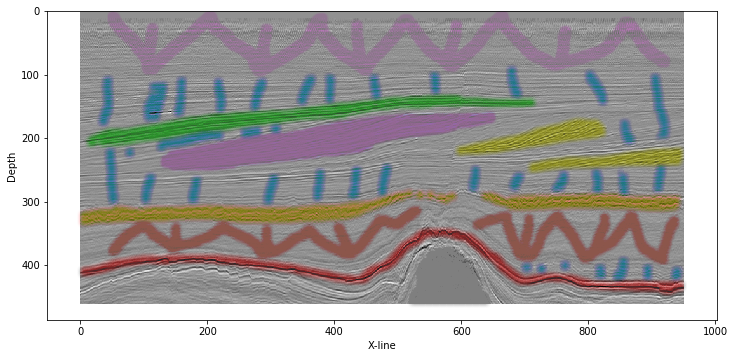

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.imshow(data[int((logs[0][0, 0] - istart) / istep)].T, cmap="gray")
for log in logs:
    plt.scatter((log[:, 1] - xstart) / xstep, (log[:, 2] - zstart) / zstep, alpha=0.005)
plt.ylabel("Depth")
plt.xlabel("X-line")
plt.show()

In [6]:
slice_data = data[int((logs[0][0, 0] - istart) / istep)]

nlogs = []
for log in logs:
    nlogs.append(np.stack([(log[:, 1] - xstart) / xstep, (log[:, 2] - zstart) / zstep]).T)

In [7]:
weights = np.array([len(log) for log in nlogs])

In [8]:
def batch_generator(slice_data, logs, weights, batch_size, sample_half_size):
    batch = []
    hs = sample_half_size
    unique_labels = np.arange(len(logs))
    labels = np.random.choice(unique_labels, p=weights, size=batch_size)
    for i in labels:
        p = logs[i][np.random.randint(0, len(logs[i]))].astype(int)
        crop = slice_data[max(p[0] - hs, 0):p[0] + hs, max(p[1] - hs, 0):p[1] + hs]
        pad = 2 * hs - np.array(crop.shape)
        if max(pad) > 0:
            crop = np.pad(crop, ((pad[0] // 2, pad[0] - pad[0] // 2),
                                 (pad[1] // 2, pad[1] - pad[1] // 2)),
                          'symmetric')
        batch.append(np.expand_dims(crop, -1))
    return np.array(batch), labels

In [10]:
import tensorflow as tf

config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    images = tf.placeholder('float', shape=(None, 24, 24, 1), name='images')
    labels = tf.placeholder('float', shape=(None, len(nlogs)), name='labels')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    conv = tf.layers.conv2d(images, 8, (3, 3), padding='same')
    conv = tf.layers.conv2d(conv, 8, (3, 3), padding='same')
    conv = tf.layers.batch_normalization(conv, momentum=0.9, training=is_training)
    conv = tf.nn.elu(conv)
    conv = tf.layers.max_pooling2d(conv, (2, 2), (2, 2))
    conv = tf.layers.dropout(conv, rate=0.1, training=is_training)
    
    conv = tf.layers.conv2d(conv, 16, (3, 3), padding='same')
    conv = tf.layers.conv2d(conv, 16, (3, 3), padding='same')  
    conv = tf.layers.batch_normalization(conv, momentum=0.9, training=is_training)
    conv = tf.nn.elu(conv)
    conv = tf.layers.max_pooling2d(conv, (2, 2), (2, 2))
    conv = tf.layers.dropout(conv, rate=0.1, training=is_training)
    
    conv = tf.layers.conv2d(conv, 32, (3, 3), padding='same')
    conv = tf.layers.conv2d(conv, 32, (3, 3), padding='same')
    conv = tf.layers.batch_normalization(conv, momentum=0.9, training=is_training)
    conv = tf.nn.elu(conv)
    conv = tf.layers.max_pooling2d(conv, (2, 2), (2, 2))
    conv = tf.layers.dropout(conv, rate=0.1, training=is_training)
    
    flat = tf.layers.flatten(conv)
    
    logits = tf.layers.dense(flat, len(nlogs))    
    predict = tf.nn.softmax(logits)
#     print(predict.get_shape())

    loss = tf.losses.softmax_cross_entropy(labels, logits)

    optimizer = tf.train.AdamOptimizer()
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        step = optimizer.minimize(loss, var_list=train_vars)
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

In [11]:
import tqdm
nweights = weights / sum(weights)
batch_size = 100
half_size = 12

loss_history = []
for i in tqdm.tqdm(range(200)):
    x, y = batch_generator(slice_data, nlogs, nweights, batch_size, half_size)
    ohe = np.zeros((batch_size, len(logs)))
    ohe[np.arange(batch_size), y] = 1
    res = sess.run([loss, step], feed_dict={images: x, labels: ohe, is_training: True})
    loss_history.append(res)

100%|██████████| 200/200 [00:21<00:00,  9.74it/s]


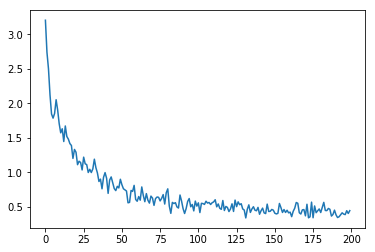

In [12]:
plt.plot(loss_history)
plt.show()

In [15]:
test_size = 1000
x, y = batch_generator(slice_data, nlogs, nweights, test_size, half_size)
ohe = np.zeros((test_size, len(logs)))
ohe[np.arange(test_size), y] = 1
out = sess.run(predict, feed_dict={images: x, is_training: False})

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y, np.argmax(out, axis=1)))

             precision    recall  f1-score   support

          0       0.69      0.66      0.68       143
          1       0.85      0.96      0.90       114
          2       0.95      0.68      0.79       107
          3       0.98      0.89      0.93        89
          4       0.83      0.89      0.86       139
          5       0.79      1.00      0.88       123
          6       0.98      0.98      0.98       158
          7       0.89      0.80      0.84        59
          8       0.90      0.82      0.86        68

avg / total       0.87      0.86      0.86      1000



In [17]:
def rolling_window(a, shape):
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
    strides = a.strides + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)

stack = rolling_window(slice_data, (2*half_size, 2*half_size))

In [27]:
x = stack.reshape((-1, 2*half_size, 2*half_size, 1))

out_labels = []
batch_size = 10000
for i in range(0, len(x), batch_size):
    res = sess.run(predict, feed_dict={images: x[i: i + batch_size], is_training: False})
    out_labels.extend(res)

In [37]:
slice_predict = np.argmax(out_labels, axis=1).reshape(stack.shape[:2])

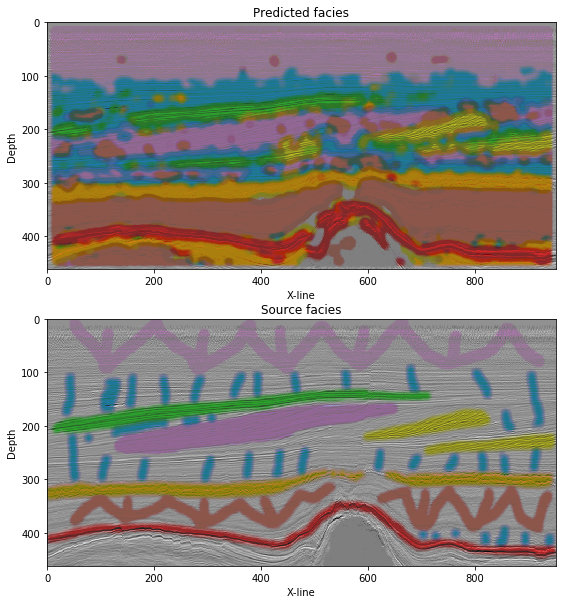

In [87]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

ax[0].set_title("Predicted facies")
ax[0].imshow(slice_data.T, cmap="gray")
for i in range(len(nlogs)):
    x, y = np.where(slice_predict == i)
    ax[0].scatter(x + half_size, y + half_size, alpha=0.01)
ax[0].set_ylabel("Depth"), ax[0].set_xlabel("X-line")
ax[0].set_xlim(0, slice_data.shape[0]), ax[0].set_ylim(slice_data.shape[1], 0)

ax[1].set_title("Source facies")
ax[1].imshow(data[int((logs[0][0, 0] - istart) / istep)].T, cmap="gray")
for log in logs:
    ax[1].scatter((log[:, 1] - xstart) / xstep, (log[:, 2] - zstart) / zstep, alpha=0.005)
ax[1].set_ylabel("Depth"), ax[1].set_xlabel("X-line")
ax[1].set_xlim(0, slice_data.shape[0]), ax[1].set_ylim(slice_data.shape[1], 0)

plt.show()